# Tutorial: Setting up a Jansen-Rit network model using YAML templates

This tutorial shows you how to set up a network model according to Jansen & Rit (Biol. Cybern., 1995). The following questions will be answered in the respective order:
1. What is a YAML template file?
2. How do I create a network model from my template?
3. How do I run simulations on my network model?
    
@Richard: Soll das Jansen-Rit-Modell hier erklärt werden oder passiert das vorher?

## Part 1: What is a YAML template file?

[YAML](https://yaml.org/spec/1.2/spec.html) is a data formatting specification that aims to be human-readable and machine-readable at the same time. It's current installment can be thought of an extension to the also popular JSON standard. 

We use YAML files to provide a simple and readable way to define network models without any Python code. Below you see a YAML template that defines the potential-to-rate operator (PRO) in a neural population. It defines an operator with the equation
$$m_{out} = \frac{m_{max}}{1. + \exp{(r \cdot (V_{thr} - PSP))}}$$
as well as all variables in that equation.

```yaml
PRO:
  base: OperatorTemplate
  equations: "m_out = m_max / (1. + exp(r*(V_thr - PSP)))"
  variables:
    m_out:
      default: output
    PSP:
      default: input
    m_max:
      default: 5.
    r:
      default: 560.
    V_thr:
      default: 6e-3
```

#### Note the following:
- PRO defines an operator, so its **`base`** is the python class `OperatorTemplate`. 
- There can be more than one equation in `equations`, but will stick to one for now
- with the keyword `default` the type and default value of variables in the given equations, the following are special variable types:
  - `input`: the variable will be provided with a value from a previous operator
  - `output`: the value of this variable will be passed to next operator
- You can also create sub-templates that overwrite parts of a template or extend it.

#### A full network model is called a *circuit* and consists of *nodes* and *edges*, which contain *operators*. 
This is a simple node template for an inhibitory interneuron population (IIN):

```yaml
IIN:
  base: NodeTemplate
  operators:
    - RPO_e
    - PRO
```

Multiple nodes are connected with edges to a circuit. The following circuit template contains one population each of pyramidal projection cells (PC), inhibitory and excitatory interneurons (IIN, EIN):

```yaml
JRC:
  base: CircuitTemplate
  nodes:
    EIN: EIN
    IIN: IIN
    PC: PC
  edges:
    - [PC/PRO/m_out, IIN/RPO_e/m_in, null, {weight: 33.75}]
    - [PC/PRO/m_out, EIN/RPO_e/m_in, null, {weight: 135.}]
    - [EIN/PRO/m_out, PC/RPO_e_pc/m_in, null, {weight: 108.}]
    - [IIN/PRO/m_out, PC/RPO_i/m_in, null, {weight: 33.75}]
```

`edges` are defined by a list with four entries:
1. The source variable (`PC/PRO/m_out` refers to variable `m_out` in operator `PRO` of node `PC`)
2. The target variable
3. An edge template with additional operators (here, `null` means that no particular edge template is used).
4. A dictionary of variables and values that are specific to this edge. 

Independent of any operators, an edge will always apply a `weight` to scale the source variable and a `delay` which defaults to zero in the above case.

## Part 2: How do I create a network model from my template?

Network models are loaded using the `frontend` module of PyRates. This module defines the template classes with a handy `.from_yaml` method to load YAML templates. For example, we can load the above operator template using the `OperatorTemplate` class: 


In [44]:
from pyrates.frontend import OperatorTemplate
template = OperatorTemplate.from_yaml("../model_templates/jansen_rit/simple_jansenrit/PRO")
template

<OperatorTemplate '../model_templates/jansen_rit/simple_jansenrit/PRO'>

Template properties are accessible via attributes, e.g.:

In [45]:
template.equations

['m_out = m_max / (1. + exp(r*(V_thr - PSP)))']

In [46]:
template.variables

{'m_out': {'default': 'output'},
 'PSP': {'default': 'input'},
 'm_max': {'default': 5.0},
 'r': {'default': 560.0},
 'V_thr': {'default': 0.006}}

__Note:__ The same can be achieved by passing the necessary data to the template class in python. You do not need to use YAML templates, if you don't want to.

In [47]:
# construct a 2nd template with the same properties, but using the class constructor instead of the YAML parser
template2 = OperatorTemplate(template.name, template.path, template.equations, 
                             template.variables, template.__doc__)

In [48]:
# verify that the contents of both templates are the same
template2.__dict__ == template.__dict__

True

### Loading a circuit template
Just like an `OperatorTemplate`, we can use `CircuitTemplate` to load a circuit:

In [49]:
from pyrates.frontend import CircuitTemplate
circuit_template = CircuitTemplate.from_yaml("../model_templates/jansen_rit/simple_jansenrit/JRC")

In [50]:
circuit_template.nodes

{'EIN': <NodeTemplate '..\model_templates\jansen_rit\simple_jansenrit\EIN'>,
 'IIN': <NodeTemplate '..\model_templates\jansen_rit\simple_jansenrit\IIN'>,
 'PC': <NodeTemplate '..\model_templates\jansen_rit\simple_jansenrit\PC'>}

### Instantiating a circuit: The Intermediate Representation
After the model has been defined using the `frontend` layer, it will be transformed into an `intermediate representation`(IR). Every template class has an `.apply()` method that does all the heavy lifting.

In [51]:
circuit = circuit_template.apply()
circuit

Note that the circuit IR the popular and powerful network graph tool `networkx`. The following interfaces are inherited from `networkx.MultiDiGraph`:

In [52]:
circuit.nodes

NodeView(('EIN.0', 'IIN.0', 'PC.0'))

In [53]:
circuit.edges

OutMultiEdgeView([('EIN.0', 'PC.0', 0), ('IIN.0', 'PC.0', 0), ('PC.0', 'IIN.0', 0), ('PC.0', 'EIN.0', 0)])

In [54]:
# reference to edge properties opeator
circuit.edges[('EIN.0', 'PC.0', 0)]

{'edge_ir': <pyrates.ir.edge.EdgeIR at 0x1de4ee41668>,
 'weight': 108.0,
 'delay': None,
 'source_var': 'PRO.0/m_out',
 'target_var': 'RPO_e_pc.0/m_in'}

### Visualize the network

Using `networkx`, we can draw a simple representation of our network:

**Note:** Multiple edges are displayed as one line

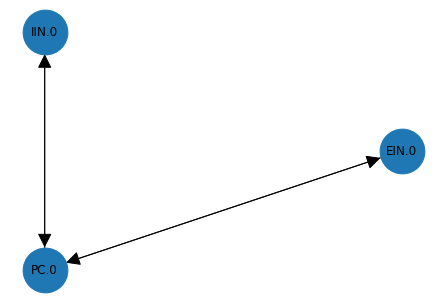

In [55]:
import matplotlib.pyplot as plt
import networkx as nx
pos=nx.spring_layout(circuit.graph)
nx.draw_shell(circuit.graph, with_labels=True, node_size=2000, arrowsize=30)

The following a custom implementation using `pydot`:

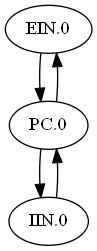

In [56]:
from pyrates.utility.visualization import plot_network_graph
plot_network_graph(circuit)

## Part 3: How do I run simulations on my network model?

The *intermediate representation* is a user-friendly representation of a network model. Computations are realised via a *computation backend*. In the backend, the IR is restructured into what we call the `ComputeGraph`:

In [57]:
T = 10.0
dt = 0.0001
from pyrates.backend import ComputeGraph
net = ComputeGraph(circuit , vectorization="nodes", dt=dt)


Note that the reorganised network consists of 2 instead of 3 nodes, because the EIN and IIN nodes actually contain the same equations:

In [80]:
net.net_config.nodes

NodeView(('IIN_EIN_all.0', 'PC_all.0'))

Simulations are started using the `.run` method of our `ComputeGraph`. Note that we are using a so called *placeholder* variable `u` to pass external input to drive the circuit. The variable `u` is contained in the operator `RPO_e_pc.0` of our `PC` node:

In [87]:
import numpy as np
ext_input = 200 +  np.random.normal(scale=20*np.sqrt(dt), size=int(T/dt))
results = net.run(simulation_time = T, 
                  outputs={'V': ('PC', 'PRO.0', 'PSP')}, 
                  inputs={('PC', 'RPO_e_pc.0', 'u'): ext_input})

Simulation results are returned as a handy `pandas.DataFrame`:

In [89]:
results.head()

var,V
node,PC
0.0000,0.000000e+00
0.0001,6.489055e-07
0.0002,1.932033e-06
0.0003,3.835627e-06
0.0004,6.345845e-06


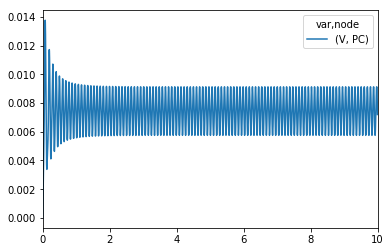

In [88]:
results.plot()